# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB03.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Ada D'Iorio
**ID Number**: 2092320

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None: #non funziona
        axis.scatter(data[:,0], data[:,1], data[:,2], c=data, marker="o",  s=5) #c è un parametro opzionale e contiene l'informazione sul colore dei punti 
    else: 
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2092320  # insert your ID number here
np.random.seed(ID)

Load the provided images and display them (if you like you can experiment with other images)

C:\Users\adadi\AppData\Local\Temp\ipykernel_25228\1124809837.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


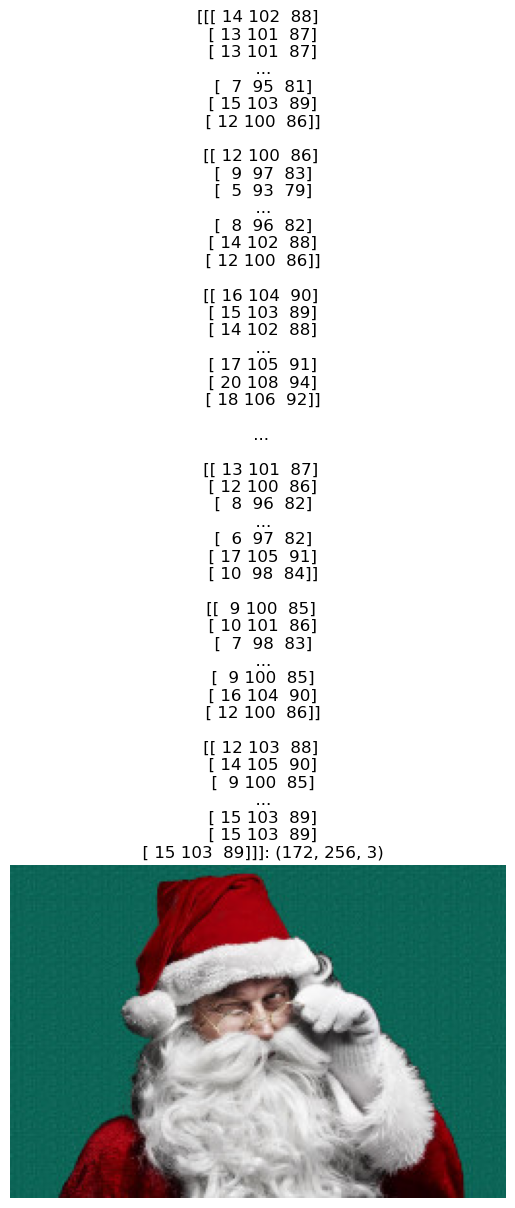

In [8]:
# To load the images use the function plt.imread(<path_to_iamge>)
landscape = plt.imread('C:\\Users\\adadi\\OneDrive\\Desktop\\machine learning\\lab3\\data\\landscape.jpg')
reindeer = plt.imread('C:\\Users\\adadi\\OneDrive\\Desktop\\machine learning\\lab3\\data\\reindeer.jpg')
stclaus = plt.imread('C:\\Users\\adadi\\OneDrive\\Desktop\\machine learning\\lab3\\data\\santaclaus2.jpg')


# Plot the images with their shapes
# Sugestion: use the function img_plot()
#img_plot(landscape)
#img_plot(reindeer)
img_plot(stclaus, title = stclaus)


We are going to start by using the Santa Claus image.


In [9]:
# Reshape the data to a matrix of num_pixels x 3 
img_array = stclaus

num_pixel = img_array.shape[0] * img_array.shape[1] 
#print(img_array.shape)
normalized_img = img_array.reshape(num_pixel, 3)
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
normalized_img = normalized_img/255

# Print the shape of the data and the min and max values of the pixels
print("New shape of the data: ", normalized_img.shape)
print("Max and min values of the normalized data: ", normalized_img.max(), normalized_img.min())


normalized_img[:,0]

New shape of the data:  (44032, 3)
Max and min values of the normalized data:  1.0 0.0


array([0.05490196, 0.05098039, 0.05098039, ..., 0.05882353, 0.05882353,
       0.05882353])

Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

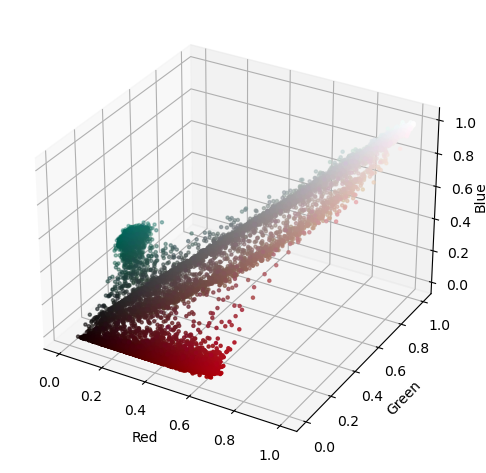

In [10]:
# Sugestion: use the function scatter_plot()
scatter_plot(normalized_img) 
#SISTEMARE: mi da un errore sulla shape di c, c'è un errore nella funzione di plot 

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [44]:
import itertools

def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    
    #divido il dataset in k cluster
    num_elements = np.size(points) / k #numero di elementi per ogni cluster 
    
    #Devo dividere il dataset in k cluster 
    points_divided = np.array_split(points, k)
     #lista di array in cui ho diviso il dataset 

    centroids_idx = np.random.choice(points.shape[0], size=k, replace=False)
    centroids = points[centroids_idx]

    prev_error = 100000 #inizializzo l'errore 
    errors = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (errors[iters] != prev_error) and iters < max_iters:
        #distances = np.linalg.norm(points[:, np.newaxis] - centroids, axis = 2)
        #closest_centroids = np.argmin(distances, axis = 1)
        
        distances = np.zeros((points.shape[0], centroids.shape[0]))
    
        
        for i in range(points.shape[0]):
            for j in range(centroids.shape[0]):
                distances[i,j] = np.linalg.norm(points[i] - centroids[j])
        
        clusters = np.array([np.argmin(d) for d in distances])
        
        # Calculate mean for every cluster and update the center
        #new_centroids = np.array([points[closest_centroids == c].mean(axis= 0) for c in range(k)])
            
        centroids = np.array([np.mean(points[clusters == i], axis = 0) for i in range(k)])
            
        # Update the error
        #L'errore totale è dato dalla somma su tutti i cluster delle distanze di ogni punto dal rispettivo centroide
        prev_error = errors[iters]
        
        new_error = 0
        
      
        for centroid, cluster_number in zip(centroids, range(k)):
            cluster_points = points[clusters == cluster_number]
            cluster_distances = np.sum([np.linalg.norm(point - centroid)**2 for point in cluster_points])
            new_error += cluster_distances
        
        errors.append(new_error)
        # Update the iteration counter

        iters += 1

    return centroids, clusters, errors

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

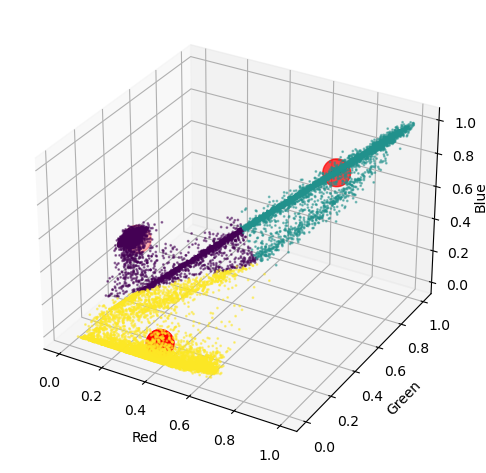

In [45]:
# Run your K-means function on the data
centroids, labels, error = my_kmeans(normalized_img, k = 3, max_iters = 100)

color = []
for i in labels:
        color.append(centroids[i])
        
array_unificato = [elemento for subarray in color for elemento in subarray]
color =  np.array(array_unificato).reshape((normalized_img.shape))
#color.reshape(normalized_img)

color = centroids[labels]
#centroids.reshape(normalized_img.shape)
scatter_plot(normalized_img, labels, centroids)

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

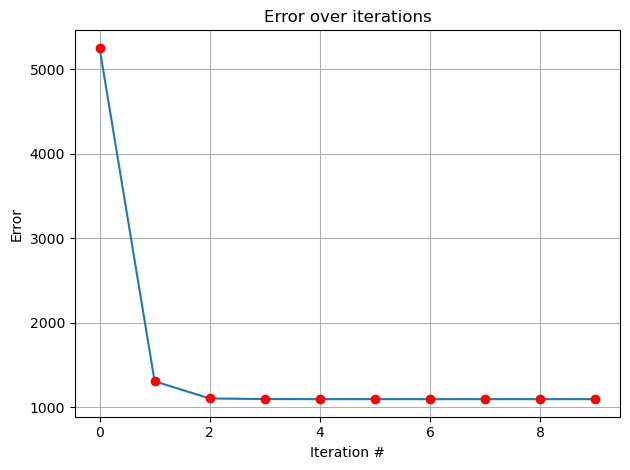

[9999,
 5251.594418648629,
 1304.0099929110004,
 1101.4674109002622,
 1093.8386237490054,
 1093.014018202056,
 1092.9019415908942,
 1092.8827166077135,
 1092.877269729635,
 1092.8767238335545,
 1092.876549748246,
 1092.876549748246]

In [46]:
# Sugestion: use the function error_plot()
error_plot(error)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [47]:
# Define the K-means model
n_init = 10
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters, init='random', max_iter = 50)

# Fit the model to the data
kmeans.fit(normalized_img)
    
# Get the cluster centers
labels_2 = kmeans.labels_
centers = kmeans.cluster_centers_


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Perform the same plot as above but with the output of the k-means function provided in sklearn.

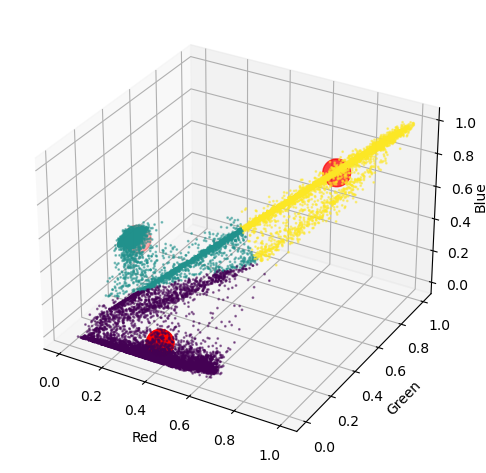

In [48]:
#print(cluster_images[0].shape) #non ho capito se si riferisce al plot degli errori oppure al grafico tridimensionale 
scatter_plot(normalized_img, labels_2, centers)

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q1:** 
In both the graphs the centroids are distributed in the same positions. Probably this is due to the inizialization of the centroids, that have been inizialized in a random way for both the algorithms.
We expect to obtain an image for both plots that is really similar.

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

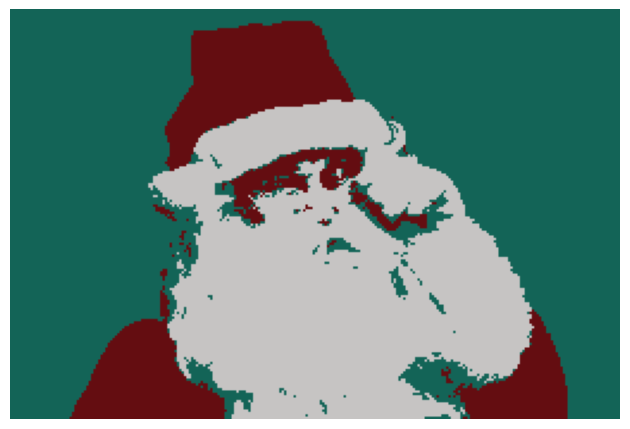

In [49]:
# Extarct the color values of the centers
#print(kmeans.labels_) 
#print(kmeans.cluster_centers_) #restituisce le coordinate dei punti nello spazio tridimensionale
#dopo aver performato il fit, devo sostituire ogni pixel al suo cluster corrispondente,
#sostituiendo ogni pixel nell'immagine con il valore del centroide del cluster a cui appartiene 

reconstructed_image = centers[labels_2].reshape(img_array.shape)
#colors = kmeans.cluster_centers_(kmeans.labels_)

img_plot(reconstructed_image)

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

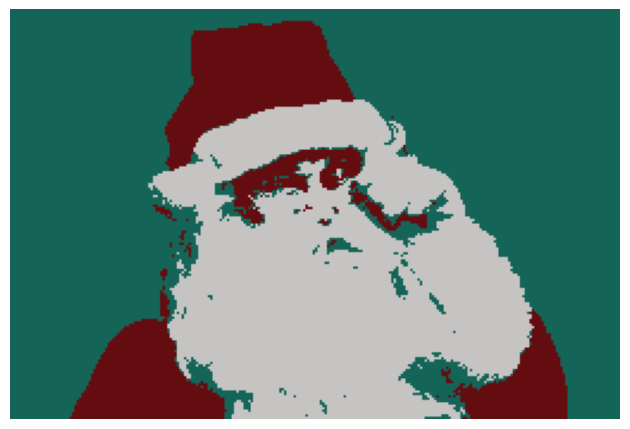

In [50]:
# Extarct the color values of the centers
#print(centroids)
#print(centroids[LABELS].shape) #non riesco a capire ma la dimensione qui è diversa rispetto al caso precedente

#my_reconstructed_img = centroids[LABELS].reshape(img_array.shape)

#img_plot(my_reconstructed_img)

# Reshape the data to the original image shape
reconstructed_image_2 = color.reshape(img_array.shape)

# Plot the recolored image
img_plot(reconstructed_image_2)



### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q2:** 
I have obtained a really similar image with the two algorithms. In my opinion, clustering is useful for image segmentation because it helps to reduce the size of an image without losing the information about the object that is being represented. In fact, it's always possible to distinguish the figure in the image but it has a worse quality.

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

120 160
Maximum value:  1.0 
Minimum value:  0.0

K-means clustering with different values of K (2-15):


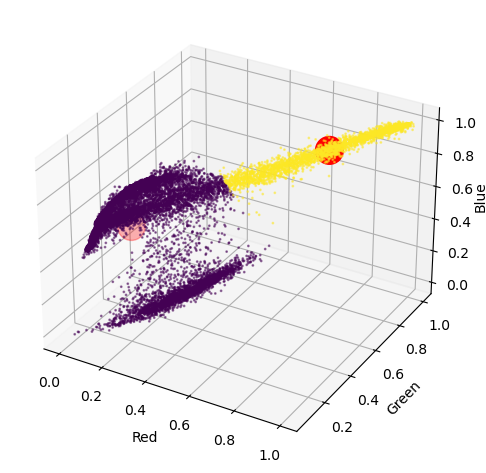

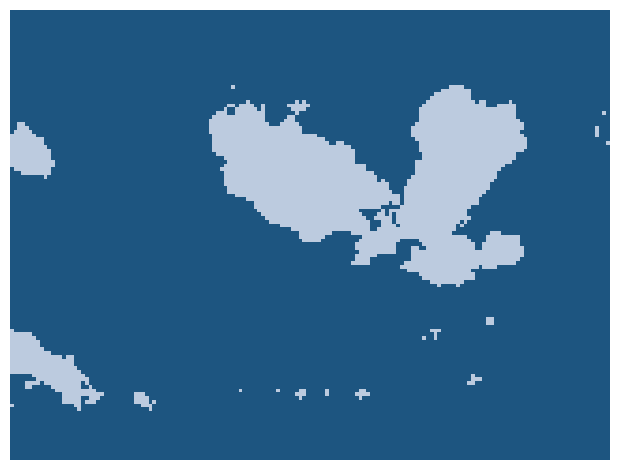

Computational time for k =  2 
 0.91 s


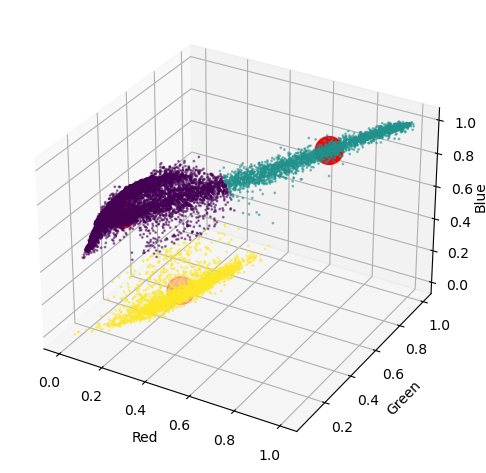

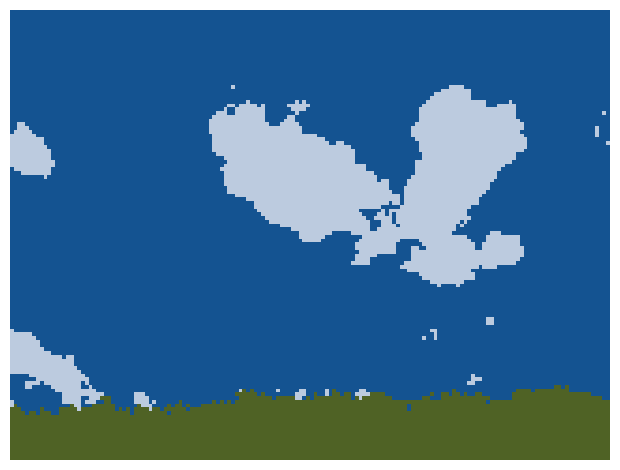

Computational time for k =  3 
 1.10 s


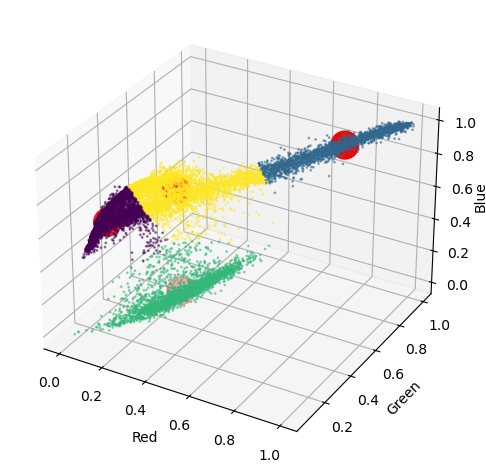

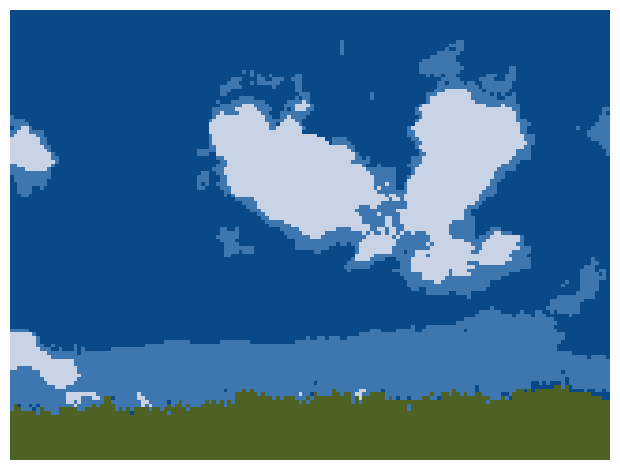

Computational time for k =  4 
 1.09 s


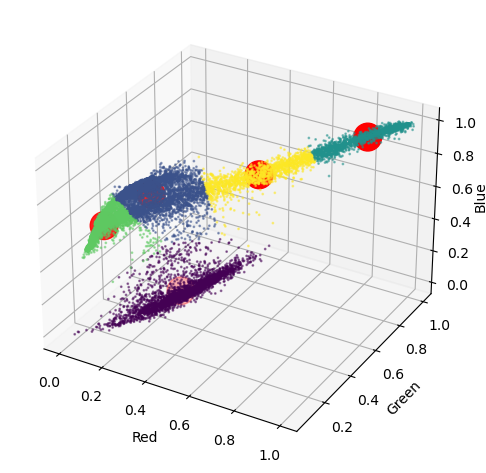

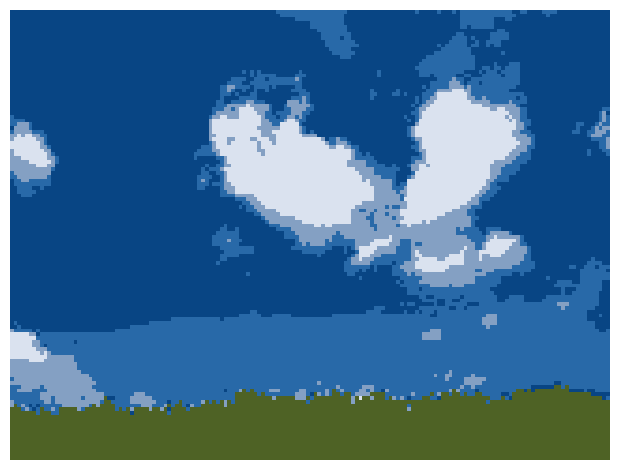

Computational time for k =  5 
 1.38 s


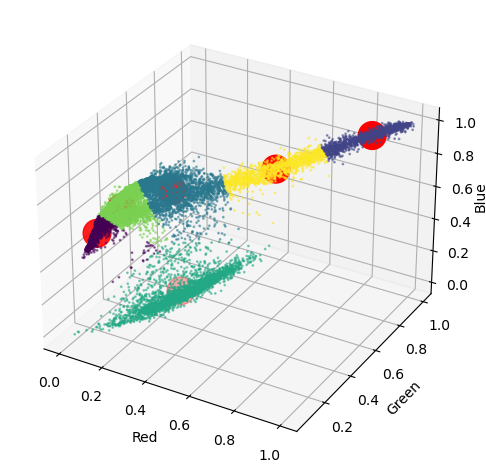

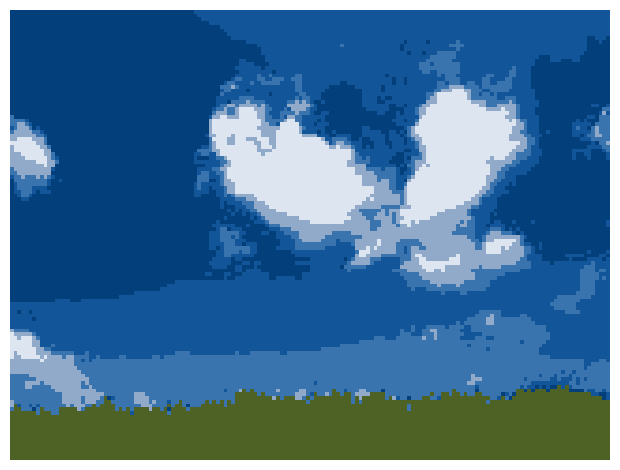

Computational time for k =  6 
 1.24 s


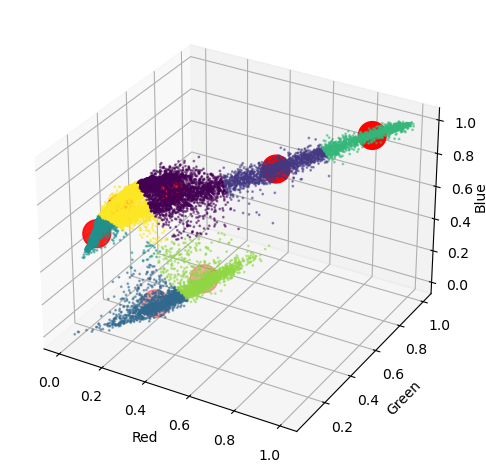

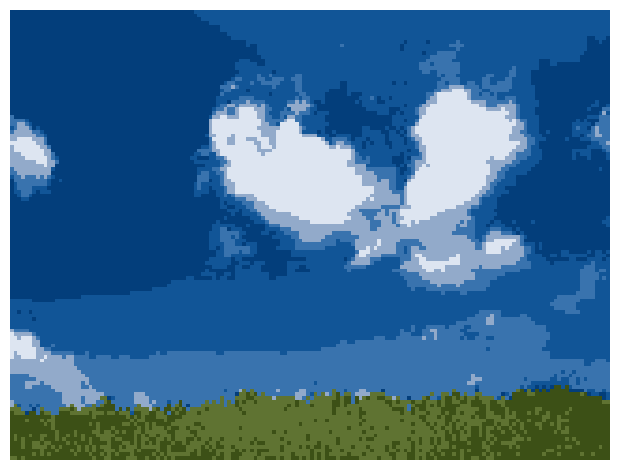

Computational time for k =  7 
 1.15 s


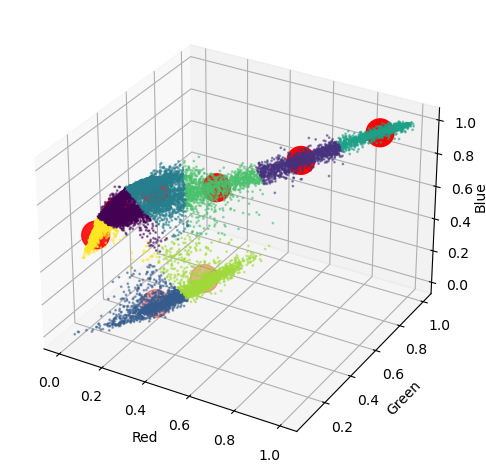

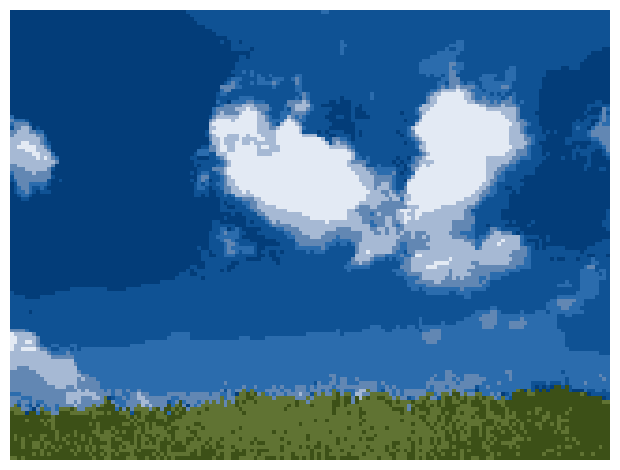

Computational time for k =  8 
 1.18 s


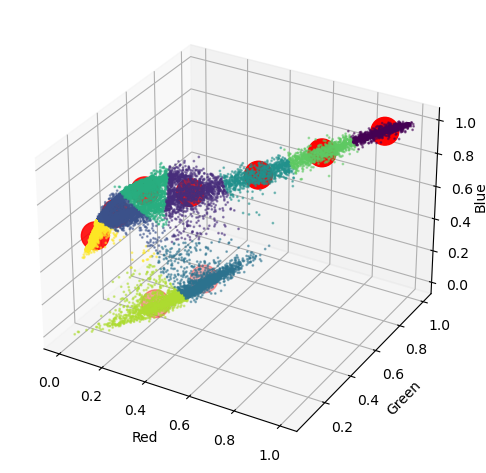

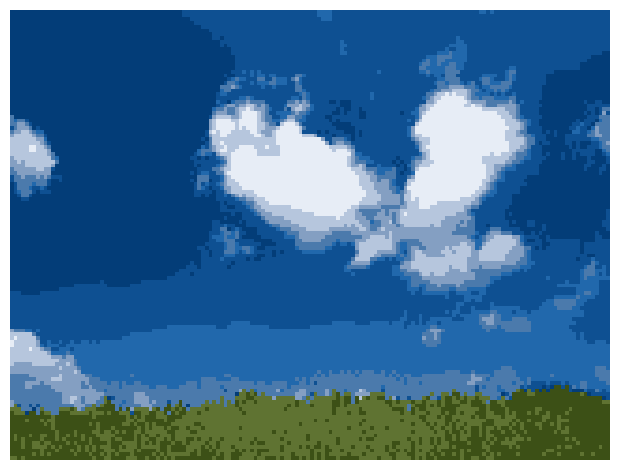

Computational time for k =  9 
 1.17 s


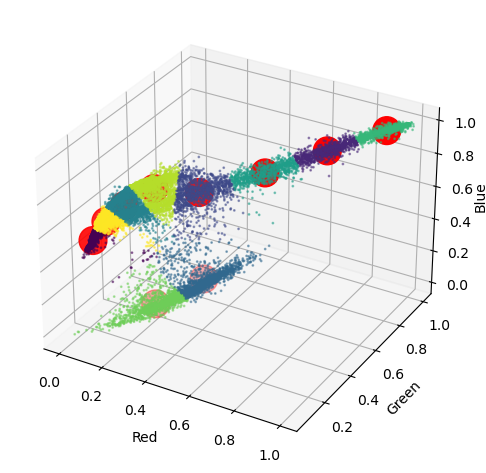

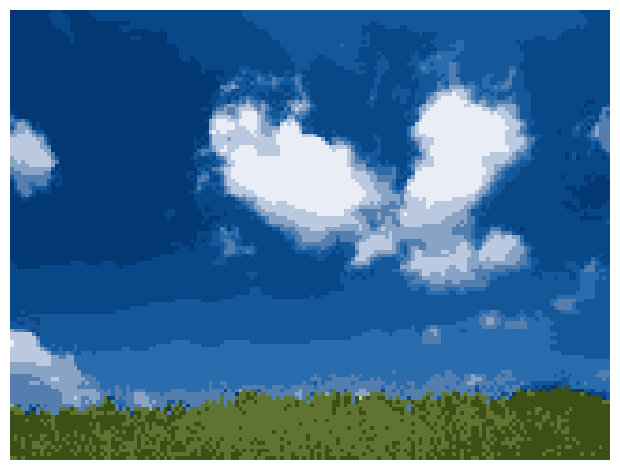

Computational time for k =  10 
 1.29 s


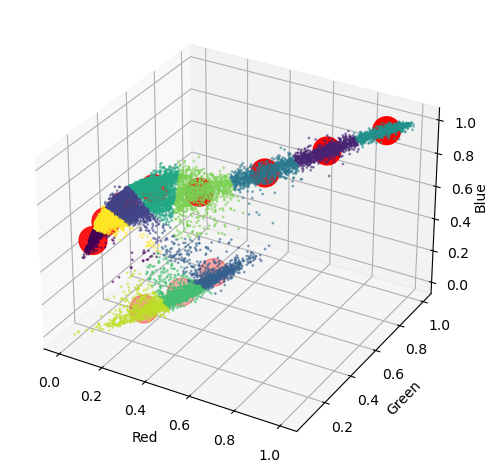

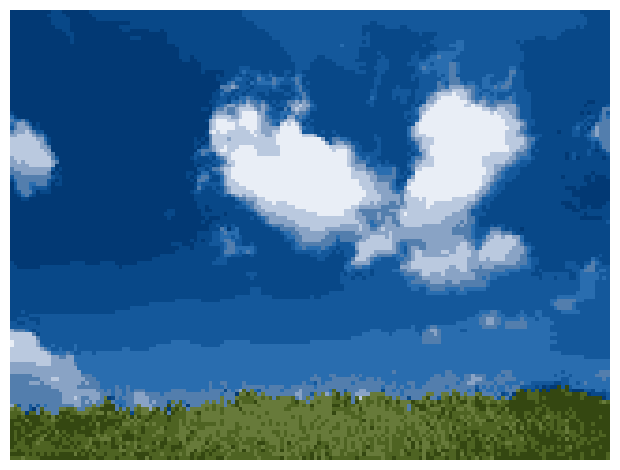

Computational time for k =  11 
 1.11 s


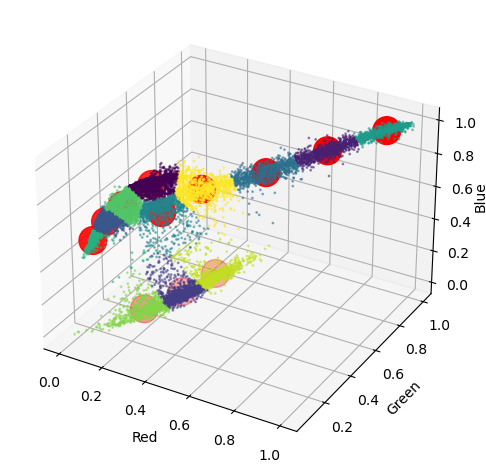

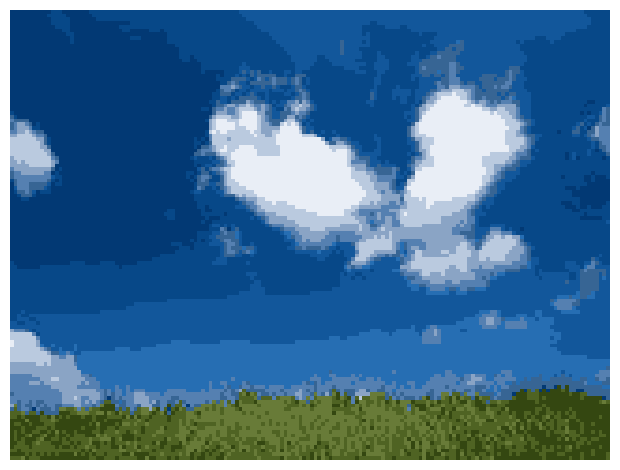

Computational time for k =  12 
 1.26 s


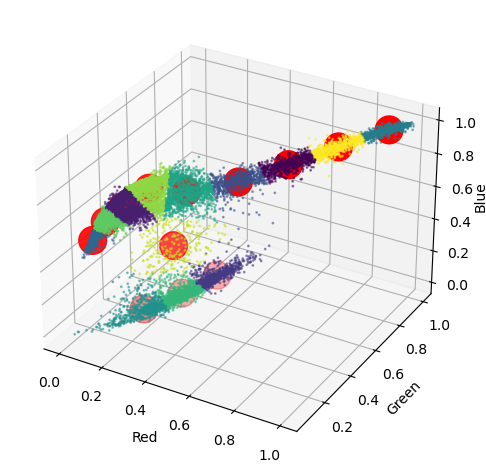

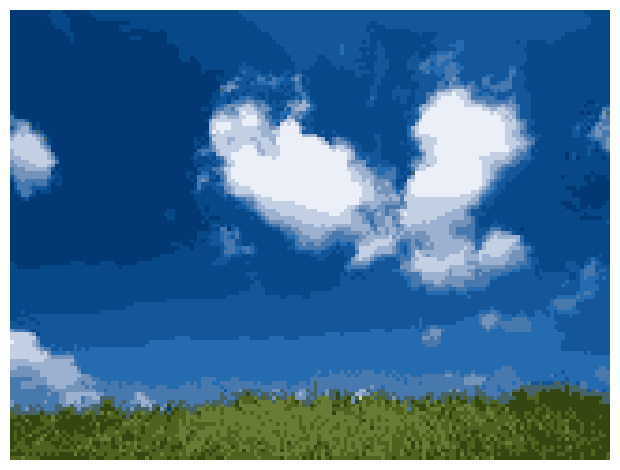

Computational time for k =  13 
 1.19 s


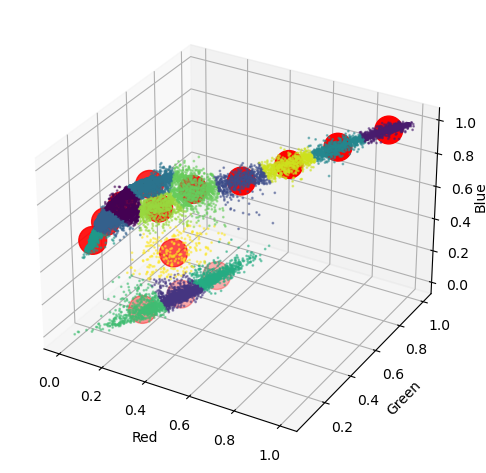

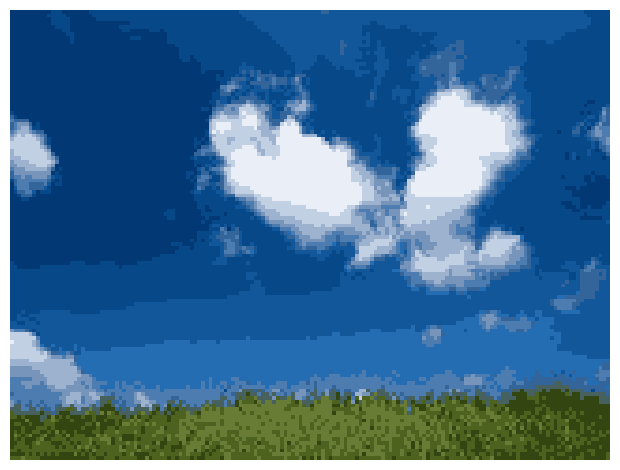

Computational time for k =  14 
 1.35 s


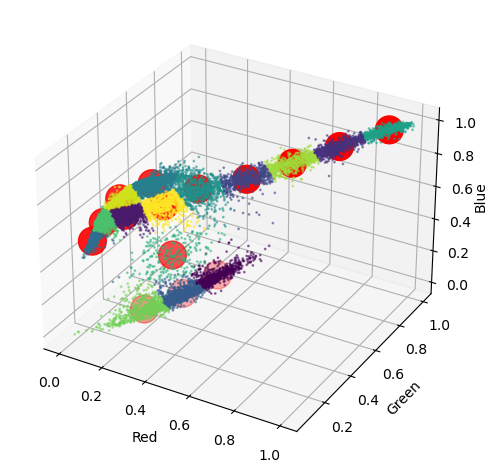

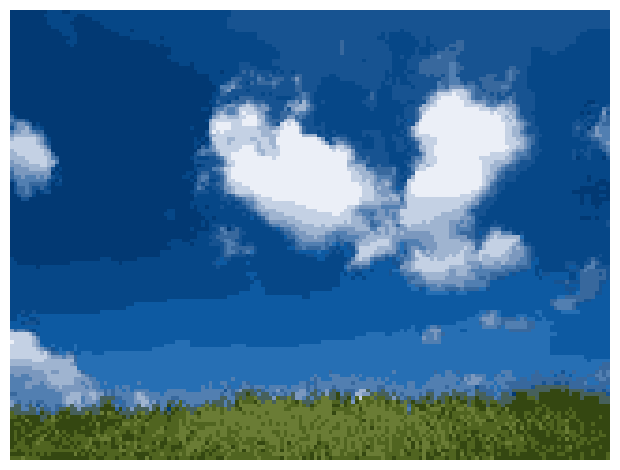

Computational time for k =  15 
 1.43 s


In [63]:
import time 


# Reshape the data to a matrix of total_num_pixels x 3
img_array = np.array(landscape)

original_shape = img_array.shape

num_pixel = img_array.shape[0] * img_array.shape[1]

normalized_img = img_array.reshape(num_pixel, 3)

normalized_img = normalized_img/255

# Print the shape of the data and the min and max values of the pixels
print(img_array.shape[0], img_array.shape[1])
print("Maximum value: ", normalized_img.max(), "\nMinimum value: ", normalized_img.min())

#img_plot(normalized_img)
# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
TIME = []

for k in range(2,16):
    time_0 = time.time()
    # Define the K-means model
    n_init = 10
    num_clusters = k
    
    kmeans = KMeans(n_clusters = num_clusters, n_init = n_init)

    # Fit the model to the data
    kmeans.fit(normalized_img)
   
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Extarct the color values of the centers
    cluster_labels = kmeans.labels_
    
    # Reshape the data to the original image shape
    img_array.reshape(original_shape)

    # Update the inertia
    inertia += (kmeans.inertia_ ,)

    # Plot the scatter plot and the ricolored imag
    scatter_plot(normalized_img, cluster_labels, cluster_centers)
    
    
    # Plot the recolored image
    reconstructed_image = cluster_centers[cluster_labels].reshape(img_array.shape)
    img_plot(reconstructed_image)
    
    time_f = time.time() 
    print("Computational time for k = ", k, "\n" , f"{time_f - time_0:.2f}", "s")
    
    TIME.append(time_f - time_0)

In [ ]:
# Reshape the data to a matrix of total_num_pixels x 3
img_array = np.array(reindeer)

original_shape = img_array.shape

num_pixel = img_array.shape[0] * img_array.shape[1]

normalized_img = img_array.reshape(num_pixel, 3)

normalized_img = normalized_img/255

# Print the shape of the data and the min and max values of the pixels
print(img_array.shape[0], img_array.shape[1])
print("Maximum value: ", normalized_img.max(), "\nMinimum value: ", normalized_img.min())

#img_plot(normalized_img)
# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    n_init = 10
    num_clusters = k
    
    kmeans = KMeans(n_clusters = num_clusters, n_init = n_init)

    # Fit the model to the data
    kmeans.fit(normalized_img)
   
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Extarct the color values of the centers
    cluster_labels = kmeans.labels_
    
    # Reshape the data to the original image shape
    img_array.reshape(original_shape)

    # Update the inertia
    inertia += (kmeans.inertia_ ,)
    
    # Plot the scatter plot and the ricolored imag
    scatter_plot(normalized_img, cluster_labels, cluster_centers)
    
    # Plot the recolored image
    reconstructed_image = cluster_centers[cluster_labels].reshape(img_array.shape)
    img_plot(reconstructed_image)

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

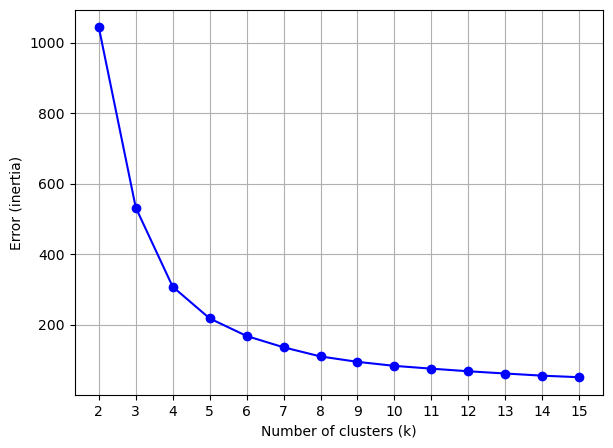

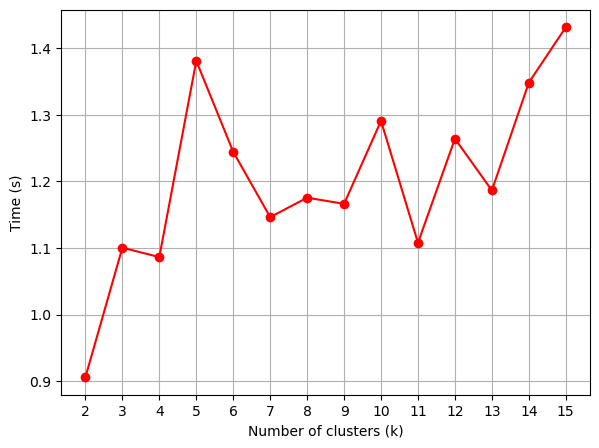

In [66]:
k_values = []
errors = []

min_k = 2
max_k = 15

for k in range(min_k, max_k + 1):
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(normalized_img)
    
    k_values.append(k)
    errors.append(kmeans.inertia_)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(k_values, errors, marker = 'o', linestyle = '-', color = 'b')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Error (inertia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 2)
plt.plot(k_values, TIME, marker = 'o', linestyle = '-', color = 'r')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Time (s)")
plt.xticks(k_values)
plt.grid(True)

plt.show()


In [55]:
for i in range(len(errors)):
    print(f'Inertia with {i+2} clusters: {errors[i]}')

Inertia with 2 clusters: 1043.6727642883213
Inertia with 3 clusters: 532.0001641358109
Inertia with 4 clusters: 307.22291382660705
Inertia with 5 clusters: 217.378980821987
Inertia with 6 clusters: 167.53233013116952
Inertia with 7 clusters: 135.40411362090867
Inertia with 8 clusters: 109.39263868297216
Inertia with 9 clusters: 94.16855721600716
Inertia with 10 clusters: 82.72970219770556
Inertia with 11 clusters: 74.82378592507528
Inertia with 12 clusters: 67.24939428736424
Inertia with 13 clusters: 60.99141172206406
Inertia with 14 clusters: 55.4778929991095
Inertia with 15 clusters: 50.19242886392057


### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** 
Improving the number of clusters, the quality of the image being represented becomes really much better. Considering also the computational time, I can say that the optimal value of k will be around 10/11, also because the error is really small comparing with a smaller number of clusters. It's not possible to say in a clear way which is the really optimal value, also because the algorithm gives back a recognizable figure starting from k = 5, it can be helpful for image compression.

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [184]:
# Load sample data
data = np.load("C:\\Users\\adadi\\OneDrive\\Desktop\\machine learning\\lab3\\data\\moon_data.npz") # ADD YOUR CODE HERE (use np.load())

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from sklearn on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [185]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
agg_clustering = AgglomerativeClustering(n_clusters = 2, linkage='single')

# Fit the model to the data
agg_clustering.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
cluster_labels = agg_clustering.labels_

# Print the results
print(cluster_labels)

[1 0 1 ... 1 0 1]


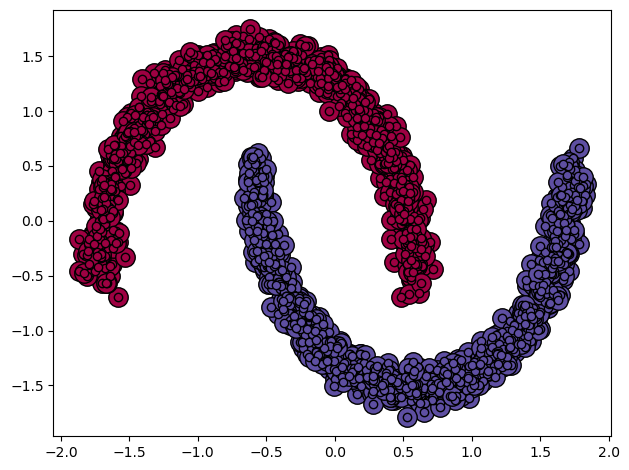

In [186]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(cluster_labels, x)

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


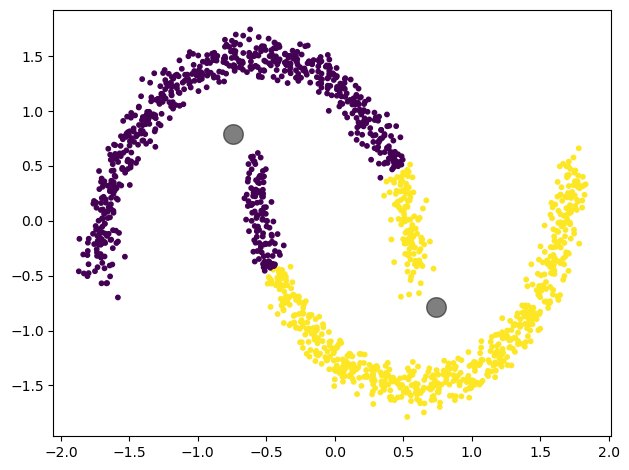

In [187]:

# Define the K-means model
kmeans = KMeans(n_clusters = 2, n_init=n_init)

# Fit the model to the data
kmeans.fit(x)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Extarct the color values of the centers
cluster_labels = kmeans.labels_

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, cluster_labels, cluster_centers)

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** The classification results to be more accurate using Agglomerative Clustering. In Agglomerative Clustering, each data sample is a single-point cluster. All close clusters are merged together until the termination condition. In the end, all the points are in a cluster.
In the k-means algorithm, we compute the distance between each data point and the centroids.
The Agglomerative Clustering results to be more efficient in this case because it fits better the image that we are now considering. It is able to separe the two figures in a better way.

---